## Instructions
To successfully run the following notebook, in the output of the first cell you need to insert a valid Llama2 access token. This token can be requested on their model card (https://huggingface.co/meta-llama/Llama-2-13b-hf).

Recommended is a GPU

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer
from torch.utils.data import Dataset
import torch
import pandas as pd
import evaluate
import numpy as np  
import pandas as pd
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType
import bitsandbytes as bnb
import datasets
from datasets import load_dataset
import transformers
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
notebook_login()

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


In [2]:
# Count GPUs
print(torch.cuda.device_count())


0


In [3]:
# Count GPUs
print("Available GPUs:", torch.cuda.device_count())

# Set CUDA_VISIBLE_DEVICES to use only GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Count GPUs again to see if the change took effect
print("Available GPUs after setting CUDA_VISIBLE_DEVICES:", torch.cuda.device_count())

# Move the model to the appropriate device
device = torch.device("cuda:1") 
print("Using device:", device)

Available GPUs: 0
Available GPUs after setting CUDA_VISIBLE_DEVICES: 0
Using device: cuda:1


In [6]:
model_id = "meta-llama/Llama-2-13b-hf" #"meta-llama/Llama-2-7b-hf" 
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.add_special_tokens({"pad_token":"<pad>"}) 

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

c:\Users\jonas\anaconda3\envs\botox\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jonas\.cache\huggingface\hub\models--meta-llama--Llama-2-13b-hf. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

1

In [4]:
bot_train = datasets.load_from_disk("../../../dataset/bot_ds_right")["train"] # change 
no_bot_train = datasets.load_from_disk("../../../dataset/no_bot_ds_right")["train"] # change 
bot_train = bot_train.add_column("output", [1]*len(bot_train))  
no_bot_train = no_bot_train.add_column("output", [0]*len(no_bot_train))
train_dataset = datasets.concatenate_datasets([bot_train, no_bot_train])
train_dataset = train_dataset.shuffle(10)
train_sentences, train_labels = train_dataset['text'], train_dataset['output']

In [5]:
bot_val = datasets.load_from_disk("../../../dataset/bot_ds_right")["val"] # change 
no_bot_val = datasets.load_from_disk("../../../dataset/no_bot_ds_right")["val"] # change 
bot_val = bot_val.add_column("output", [1]*len(bot_val))  
no_bot_val = no_bot_val.add_column("output", [0]*len(no_bot_val)) 
val_dataset = datasets.concatenate_datasets([bot_val, no_bot_val])
val_dataset = val_dataset.shuffle(10)
val_sentences, val_labels = val_dataset['text'], val_dataset['output']

In [39]:
# Split into training and validation sets
train_encodings = tokenizer(train_sentences, truncation=True, max_length=512, padding='max_length', return_attention_mask=True)
val_encodings = tokenizer(val_sentences, truncation=True, max_length=512, padding='max_length', return_attention_mask=True)

In [41]:
# Create torch dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [42]:
# Prepare datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [43]:
len(train_dataset)

12688

In [44]:
len(val_dataset)

3173

In [45]:
### Prepare model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32  #bfloat
)

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                        quantization_config=bnb_config,
                                                        trust_remote_code=True,
                                                        num_labels=len(set(train_labels)))

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-13b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 5120)

In [47]:
model.config.pad_token_id = tokenizer.pad_token_id

In [48]:
model = prepare_model_for_kbit_training(model)

In [49]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [50]:
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [51]:
modules = find_all_linear_names(model)
modules

['down_proj', 'k_proj', 'q_proj', 'up_proj', 'v_proj', 'o_proj', 'gate_proj']

In [53]:
model_directory = "./models/"

config = LoraConfig(
    r=16, 
    lora_alpha=64, 
    target_modules=modules, 
    lora_dropout=0.4, 
    bias="none", 
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, config)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    logging_dir=model_directory, 
    output_dir=model_directory,    # change     
    evaluation_strategy='epoch', 
    load_best_model_at_end = True,
    logging_steps = 100, 
    logging_strategy="epoch",
    report_to="none",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    save_total_limit=2,
    save_strategy= "epoch",
    optim="paged_adamw_32bit", 
    learning_rate = 2e-5,
    fp16 = True, 
    push_to_hub=False,
)
print_trainable_parameters(model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks=[transformers.EarlyStoppingCallback(early_stopping_patience=1)]
)
model.config.use_cache = False  # silence the warnings. please re-enable for inference!
do_train = True

def log_memory_usage():
    mem_alloc = torch.cuda.memory_allocated() / 1024**3  # Memory usage in GB
    print(f"Memory Usage: {mem_alloc:.2f} GB")

# Launch training and log metrics
print("Training...")

# Enable anomaly detection
# torch.autograd.set_detect_anomaly(True)

if do_train:
    train_result = trainer.train()
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()
    log_memory_usage()
    print(metrics)

trainable params: 62597120 || all params: 6570752000 || trainable%: 0.9526629524291892
Training...


/home/stjowort/botox/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/stjowort/botox/venv/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:391: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn('Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')
/home/stjowort/botox/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.ch

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.125500,0.045943,0.988024,0.991201,0.985009,0.988095
2,0.017700,0.053016,0.988339,0.990590,0.986259,0.988419


/home/stjowort/botox/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/stjowort/botox/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** train metrics *****
  epoch                    =         2.0
  total_flos               = 925724286GF
  train_loss               =      0.0716
  train_runtime            =  3:30:29.46
  train_samples_per_second =       2.009
  train_steps_per_second   =       0.251
Memory Usage: 7.90 GB
{'train_runtime': 12629.4656, 'train_samples_per_second': 2.009, 'train_steps_per_second': 0.251, 'total_flos': 9.93988883471401e+17, 'train_loss': 0.07158571474188363, 'epoch': 2.0}


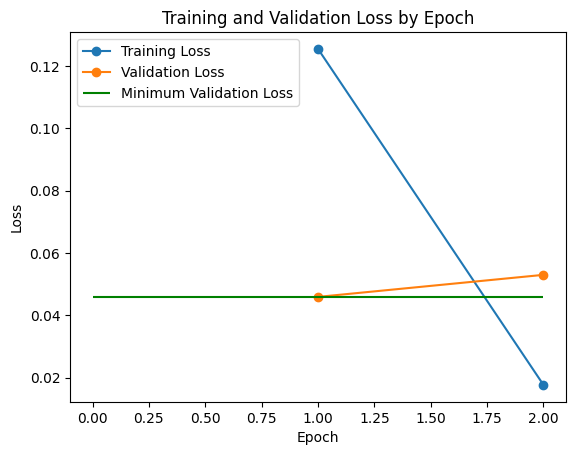

In [54]:
import json
import matplotlib.pyplot as plt
# Open the JSON file
with open(model_directory + 'trainer_state.json', 'r') as file:
    # Load the JSON data
    train_results = json.load(file)

epochs = set()
training_loss = []
val_loss = []
for item in train_results["log_history"]:
    if item.get("epoch"):
        epochs.add(item["epoch"])
    if item.get("loss"):
        training_loss.append(item["loss"])
    if item.get("eval_loss"):
        val_loss.append(item["eval_loss"])
    

epochs = list(sorted(epochs))
plt.plot(epochs, training_loss, label='Training Loss', marker="o")
plt.plot(epochs, val_loss, label='Validation Loss', marker="o")
plt.hlines(min(val_loss), 0, max(epochs), colors="green", label="Minimum Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

In [56]:
# Save model
print("Saving last checkpoint of the model...")
#os.makedirs(output_dir, exist_ok = True)
# model_directory = '/media/data/hf_models/results'
trainer.model.save_pretrained(model_directory, safe_serialization=False)

# Free memory for merging weights
del model
del trainer
torch.cuda.empty_cache()

Saving last checkpoint of the model...


In [155]:
model_directory

'/media/data/hf_models/Llama2/7b_in_steps/'

In [10]:
import torch
from peft import PeftConfig, PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSequenceClassification

PEFT_MODEL = model_directory #+ "best-model"
config = PeftConfig.from_pretrained(PEFT_MODEL)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.add_special_tokens({"pad_token":"<pad>"}) 
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

model = PeftModel.from_pretrained(model, PEFT_MODEL)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-13b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#Load Testdata 
bot_test = datasets.load_from_disk("../../../dataset/bot_ds_right")["test"]
no_bot_test = datasets.load_from_disk("../../../dataset/no_bot_ds_right")["test"]
bot_test = bot_test.add_column("output", [1]*len(bot_test))
no_bot_test = no_bot_test.add_column("output", [0]*len(no_bot_test))
test_dataset = datasets.concatenate_datasets([bot_test, no_bot_test])
test_dataset = test_dataset.shuffle(10)
test_sentences, test_labels = test_dataset['text'], test_dataset['output']

In [55]:
from tqdm import tqdm
import evaluate
metric = evaluate.load("f1")

preds = []
for sentence in tqdm(test_sentences, desc="Evaluation"):
    input = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)
    pred = model(**input) 
    preds.append(pred.logits.argmax().item())

metric.compute(predictions=preds, references=test_labels, average='binary')["f1"]

Evaluation: 100%|██████████| 3197/3197 [13:28<00:00,  3.96it/s]


0.9489762755931102